- Nome: Gabriel Lenon Barros da Silva
- Email: glbs@cesar.school
- Dataset: https://www.kaggle.com/datasets/raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables
- Objetivo: identificar frutas e vegetais frescos ou estragados a partir de suas imagens.

# Libs e Configurações necessárias

In [8]:
from torch import nn, optim, device, cuda, no_grad, max, dropout
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


device = device("cuda" if cuda.is_available() else "cpu")
print(f"Executing on the device: {device}")

Executing on the device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')
print("Drive mounted")

Mounted at /content/drive
Drive mounted


# Carregando o Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!rm -rf /content/data/train
!rm -rf /content/data/test

In [5]:
# https://drive.google.com/file/d/1ar8t3Am_LMoA5GhkysZ71Q3cH6Yq70ng/view?usp=drive_link
base_path = "/content/drive/MyDrive/Colab Notebooks/fruits_vegetables_train_and_test.zip"

!unzip -q "$base_path" -d /content/data

!ls /content/data

train_path = "/content/data/train"
test_path = "/content/data/test"

test  train


# Tratamento dos dados

In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

try:
    train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"Classes found: {train_dataset.classes}")

    print(f"Train images quantity: {len(train_dataset)}")

    print(f"Test images quantity: {len(test_dataset)}")
except Exception as e:
    print(f"Error: {e}")

Classes found: ['fresh', 'stale']
Train images quantity: 11739
Test images quantity: 2943


# Definição da Rede Neural

In [9]:
class FruitsVegetablesNetwork(nn.Module):
    def __init__(self, num_classes):
        super(FruitsVegetablesNetwork, self).__init__()

        self.input_size = 64 * 64 * 3

        self.flatten = nn.Flatten()

        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

model = FruitsVegetablesNetwork(num_classes=len(train_dataset.classes)).to(device)
print(model)

FruitsVegetablesNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=12288, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)


# Treinamento do modelo

Training started


Epoch [1/10] - Loss: 0.5352
Epoch [2/10] - Loss: 0.3571
Epoch [3/10] - Loss: 0.3101
Epoch [4/10] - Loss: 0.2632
Epoch [5/10] - Loss: 0.2412
Epoch [6/10] - Loss: 0.2113
Epoch [7/10] - Loss: 0.2058
Epoch [8/10] - Loss: 0.1890
Epoch [9/10] - Loss: 0.1755
Epoch [10/10] - Loss: 0.1659


Training finished!


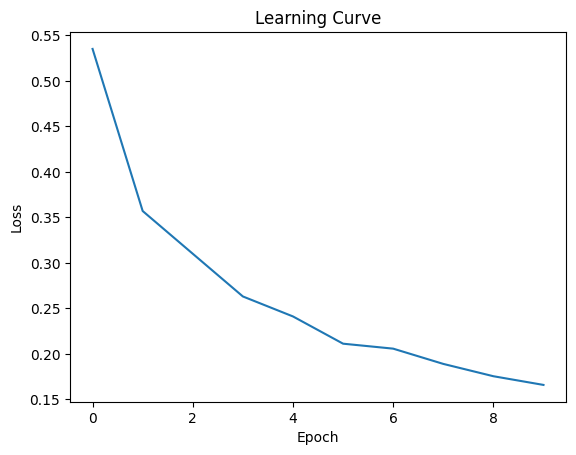

In [10]:
learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []

print("Training started")
print("\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}")

print("\n")
print("Training finished!")

plt.plot(loss_history)

plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Avaliação do modelo

In [12]:
model.eval()

correct = 0
total = 0

all_labels = []
all_preds = []

with no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)

      _, predicted = max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      all_labels.extend(labels.cpu().numpy())
      all_preds.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total

print(f'Accuracy on Test Dataset: {accuracy:.2f}%')

Accuracy on Test Dataset: 95.89%


# Analisando a Matriz de Confusão

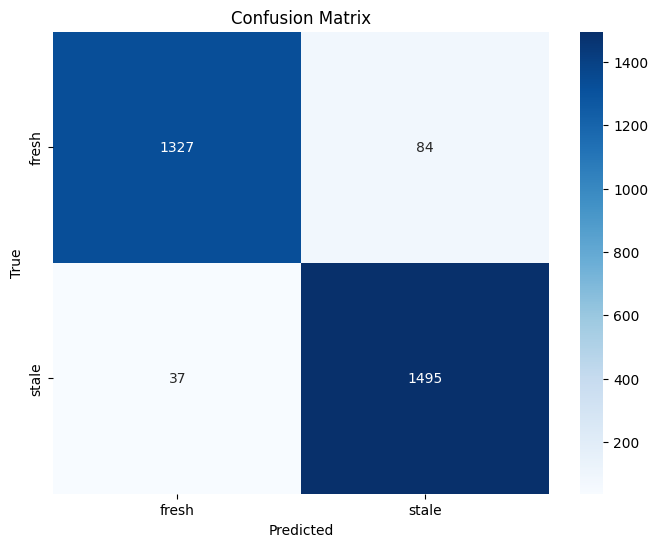

In [13]:
fruits_vegetables_confusion_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))

sns.heatmap(fruits_vegetables_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

# Analisando algumas imagens preditas corretamente e erroneamente

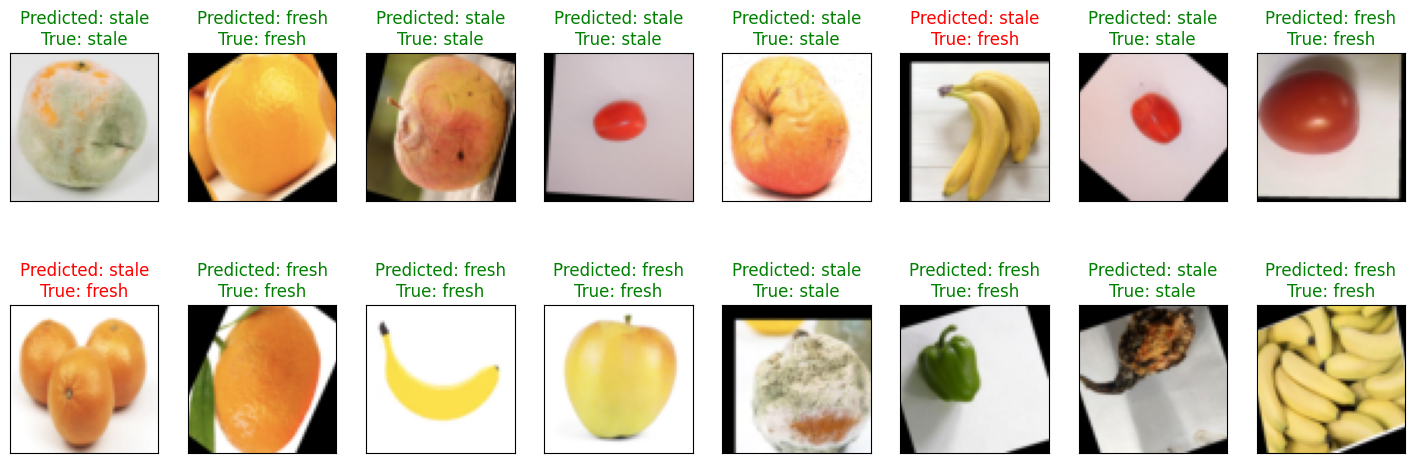

In [15]:
images_quantity = 16

test_loader_to_show = DataLoader(test_dataset, batch_size=images_quantity, shuffle=True)

data_iter = iter(test_loader_to_show)
images, labels = next(data_iter)

images = images.to(device)
labels = labels.to(device)

outputs = model(images)
_, preds = max(outputs, 1)

def show_better_image(img):
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

fig = plt.figure(figsize=(18, 6))

rows = 2
columns = int(images_quantity / rows)

for index in range(images_quantity):
    ax = fig.add_subplot(rows, columns, index+1, xticks=[], yticks=[])
    show_better_image(images[index])

    pred_label = test_dataset.classes[preds[index]]
    true_label = test_dataset.classes[labels[index]]

    ax.set_title(f"Predicted: {pred_label}\nTrue: {true_label}", color='green' if pred_label == true_label else 'red')

plt.show()

# Conclusões

- Como o conjunto de dados do kaggle fornece as imagens de frutas e vegetais frescos e estragados organizando as pastas por tipo e fruta (e.g. fresh_apple), precisei implementar um script para reorganizar as pastas de modo a ter a estrutura abaixo, facilitando a leitura das imagens e das classes-alvo (**fresh** e **stale**) pelos datasets (`torchvision`) de treino e teste, uma vez que o objetivo do modelo é identificar se as frutas/vegetais estão maduros ou velhos, independente de qual seja a fruta ou vegetal:
  - train
    - fresh/*
    - stale/*
  - test
    - fresh/*
    - stale/*
- A dificuldade principal durante todo o processo foi entender que era necessário redimensionar as imagens de sua resolução original (alta e variada) para uma resolução fixa (64x64), uma vez que a rede neural treinada é simples (multi layer perceptron), sem convolução, ou seja, treinar as imagens originais provavelmente levaria muito tempo e seria complexo.
- O conjunto de dados possui uma boa variedade de imagens de frutas e vegetais em diferentes angulações, quantidades e iluminação, o que ajudou o modelo a aprender bem e ter uma ótima acurácia (> 93%) desde a primeira iteração (após rodar o treinamento todas as épocas pela primeira vez). Isso fez com que a separação dos dados em treino-teste-validação fosse desnecessária para esse caso, uma vez que nenhum parâmetro precisou ser ajustado após a validação do modelo usando o conjunto de teste.
- Após adicionar duas camadas de **dropout** na rede, de modo a garantir a robustez do modelo, este obteve resultados ainda melhores - **acurácia acima de 95%**. Ou seja, o modelo passou a evitar ainda mais o overfitting e a generalizar melhor.
- A matriz de confusão ajuda a visualizar ainda melhor que o modelo aprendeu a generalizar bem, uma vez que a quantidade proporcional de predições corretas nas duas classes-alvo são bem próximas.
- Trabalhos futuros:
  - Realizar data augmentation com rotações e espelhamentos, para que o modelo tenha capacidade de generalização ainda maior.
  - Adicionar uma nova classe alvo (green) e novas imagens ao dataset, e então retreinar o modelo para também ser capaz de identificar frutas/vegetais verdes (não aptos para consumo).
  - Explorar arquiteturas de CNNs para que seja possível utilizar as imagens originais com resolução mais alta.

# Apêndice

## Script para organizar os datasets



```
#!/bin/bash

ROOT="./dataset"

# Destinos
TRAIN_FRESH="./train/fresh"
TRAIN_STALE="./train/stale"
TEST_FRESH="./test/fresh"
TEST_STALE="./test/stale"

# Criar destinos
mkdir -p "$TRAIN_FRESH" "$TRAIN_STALE" "$TEST_FRESH" "$TEST_STALE"

# Loop pelas frutas
for category in "$ROOT"/*/; do
    # Pega o nome da pasta (ex: fresh_apple, stale_banana)
    base=$(basename "$category")

    # Identificar tipo (fresh ou stale)
    if [[ "$base" == fresh_* ]]; then
        TYPE="fresh"
    elif [[ "$base" == stale_* ]]; then
        TYPE="stale"
    else
        echo "Ignorando pasta desconhecida: $base"
        continue
    fi

    # Nome da fruta ou vegetal (após o prefixo fresh_ ou stale_)
    ITEM="${base#*_}"

    echo "Processando $TYPE de: $ITEM"

    # Conta arquivos
    total=$(find "$category" -maxdepth 1 -type f | wc -l)
    train_count=$(( total * 80 / 100 ))
    test_count=$(( total - train_count ))

    echo " → Total: $total | Train: $train_count | Test: $test_count"

    # Selecionar 80% para treino
    find "$category" -maxdepth 1 -type f | shuf | head -n "$train_count" | while read file; do
        if [[ "$TYPE" == "fresh" ]]; then
            cp "$file" "$TRAIN_FRESH/"
        else
            cp "$file" "$TRAIN_STALE/"
        fi
    done

    # Selecionar 20% para teste
    find "$category" -maxdepth 1 -type f | shuf | head -n "$test_count" | while read file; do
        if [[ "$TYPE" == "fresh" ]]; then
            cp "$file" "$TEST_FRESH/"
        else
            cp "$file" "$TEST_STALE/"
        fi
    done

    echo " ✔ Finalizado: $base"
    echo
done

echo "🎉 Divisão concluída!"
```

